# Subreddit Stats

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as md
import numpy as np
import praw
from psaw import PushshiftAPI
import datetime
import yaml
import time
from sortedcontainers import SortedDict
from collections import OrderedDict, defaultdict
import os.path
import pickle
import re
import regex
from IPython.display import HTML
import emoji
from cycler import cycler
from multiprocessing import Pool
import copy

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The source code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the source code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
date_paradise = datetime.datetime.fromisoformat('2020-01-29').replace(tzinfo=datetime.timezone.utc)
date_ju_bd = datetime.datetime.fromisoformat('2020-05-17').replace(tzinfo=datetime.timezone.utc)
date_sy_bd = datetime.datetime.fromisoformat('2020-10-01').replace(tzinfo=datetime.timezone.utc)
date_hd_bd = datetime.datetime.fromisoformat('2020-03-26').replace(tzinfo=datetime.timezone.utc)
date_yh_bd = datetime.datetime.fromisoformat('2020-01-07').replace(tzinfo=datetime.timezone.utc)
date_scream = datetime.datetime.fromisoformat('2020-02-19').replace(tzinfo=datetime.timezone.utc)
date_boca = datetime.datetime.fromisoformat('2020-08-17').replace(tzinfo=datetime.timezone.utc)
date_online_concert = datetime.datetime.fromisoformat('2020-07-04').replace(tzinfo=datetime.timezone.utc)
date_seven_spirits = datetime.datetime.fromisoformat('2020-11-07').replace(tzinfo=datetime.timezone.utc)

In [4]:
# Parameters

start_epoch = int(datetime.datetime(2021, 11, 1).replace(tzinfo=datetime.timezone.utc).timestamp())
start_subs = 659       # number of subs at start_epoch (needed if before 2018/3/15, see redditmetrics.com)
end_epoch = min(int(datetime.datetime(2022, 1, 1).replace(tzinfo=datetime.timezone.utc).timestamp()), int(time.time()))
max_posts = None      # max number of posts to crawl, None for unlimited
sub = 'dreamcatcher'   # subreddit to crawl
num_score_calls = 5   # number of times to query score to mitigate reddit's score fuzzing
                       #     note: will drastically increase data acquisition time
cache_file = 'cache.pkl'    # cache file
skip_cache_days = 0 # skip cache for posts younger than this.
                     # i.e. always re-acquire info for posts less than this number of days old
secs_in_day = 86400

print(f'start epoch: {start_epoch}')
print(f'end epoch: {end_epoch}')

start epoch: 1635724800
end epoch: 1639630520


## Get Data

In [5]:
class Comment:
    def __init__(self):
        self.id = ''
        self.body = ''
        self.author = ''
        self.score = 0
        self.ts = 0
        self.url = ''
        self.score_arr = np.zeros((num_score_calls))

class Post:
    def __init__(self):
        self.id = ''
        self.title = ''
        self.author = ''
        self.ts = 0
        self.score = 0
        self.comments = []
        self.url = ''
        self.score_arr = np.zeros((num_score_calls))
        self.subcount = None

In [6]:
def getSubComments(comment, allComments, verbose=True):
    allComments.append(comment)
    if not hasattr(comment, "replies"):
        replies = comment.comments()
    if verbose:
        print("fetching (" + str(len(allComments)) + " comments fetched total)")
    else:
        replies = comment.replies
    for child in replies:
        getSubComments(child, allComments, verbose=verbose)


def getAll(r, submission, verbose=True):
    submission.comments.replace_more(limit=None)
    return submission.comments.list()

def save_obj(name, obj):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)
    
def word_truncate(content, length, suffix='…'):
    return content if len(content) <= length else content[:length-len(suffix)].rsplit(' ', 1)[0] + suffix

def remove_md_links(string):
    p = regex.compile(r"\[(?P<text>.+?)\]\(.+?\)")
    return p.sub(r"\g<text>", string)

def md_table_friendly(string):
    return string.replace('|', '')

In [7]:
os.makedirs('plots', exist_ok=True)
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),
})
plt.rcParams["savefig.dpi"] = 300

In [8]:
stream = open('client_info.txt', 'r')
doc = yaml.safe_load(stream)

r = praw.Reddit(client_id=doc['client_id'],
                client_secret=doc['client_secret'],
                user_agent='sub stats (by u/ipwnmice)'
                )
api_ps_praw = PushshiftAPI(r)
api_ps = PushshiftAPI()
post_ids = api_ps_praw.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['url', 'author', 'title', 'subreddit'],
                                  limit=max_posts)
subs = api_ps.search_submissions(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=sub,
                                  filter=['subreddit', 'id', 'subreddit_subscribers'],
                                  limit=max_posts)
id2subs = {}

print("counting subscribers...")
for s in subs:
    if hasattr(s, 'subreddit_subscribers'):
        num_subs = s.subreddit_subscribers
    else:
        num_subs = -1    
    id2subs[s.id] = num_subs
            
if os.path.isfile(cache_file):
    posts, subcount_temp = load_obj(cache_file)
    print('cache found')
else:
    posts = OrderedDict()
    subcount_temp = SortedDict()
prev_info_len = 1

posts_copy = copy.deepcopy(posts)

def get_submission(x):
    i, submission = x
    
    # Check cache
    if submission.id in posts_copy:
        if posts_copy[submission.id].ts + skip_cache_days*secs_in_day > time.time():
            return i, posts_copy[submission.id]
    
    # Get new submission
    submission = praw.models.Submission(r, id=submission.id)
    
    # Skip if post is deleted
    if submission.author is None or submission.selftext == '[deleted]' or submission.selftext == '[removed]':
        return i, None

    # Get comments
    comments_temp = getAll(r, submission, verbose=False)
    comments = [Comment() for _ in range(len(comments_temp))]
    for k, comment in enumerate(comments_temp):
        comments[k].body = comment.body
        comments[k].author = comment.author
        comments[k].ts = comment.created_utc
        comments[k].score = comment.score
        comments[k].permalink = comment.permalink
        comments[k].id = comment.id
        comments[k].distinguished = comment.distinguished
        comments[k].gilded = comment.gilded
        comments[k].gildings = comment.gildings
        try:
            comments[k].flair = comment.author_flair_text
        except AttributeError:
            comments[k].flair = None
        try:
            comments[k].flair_template = comment.author_flair_template_id
        except AttributeError:
            comments[k].flair_template = None
        comments[k].score_arr[0] = comment.score
    comments = [x for x in comments if x.ts <= end_epoch]

    # Populate Post fields
    post = Post()
    post.id = submission.id
    post.title = submission.title
    post.author = submission.author
    post.ts = int(submission.created_utc)
    post.comments = comments
    post.permalink = submission.permalink
    post.is_self = submission.is_self
    post.selftext = submission.selftext
    post.url = submission.url
    post.distinguished = submission.distinguished
    post.gilded = submission.gilded
    post.gildings = submission.gildings
    post.score = submission.score
    try:
        post.subcount = id2subs[submission.id]
    except KeyError:
        post.subcount = None
    try:
        post.link_flair = submission.link_flair_text
    except AttributeError:
        post.link_flair = None
    try:
        post.author_flair = submission.author_flair_text
    except AttributeError:
        post.author_flair = None
    try:
        post.link_flair_template = submission.link_flair_template_id
    except AttributeError:
        post.link_flair_template = None
    try:
        post.author_flair_template = submission.author_flair_template_id
    except AttributeError:
        post.author_flair_template = None
        
    return i, post

print('fetching data...')
with Pool(20) as p:
    for i, post in p.imap(get_submission, enumerate(post_ids)):
        if post is None:
            continue
            
        # Save to cache
        if post.ts not in subcount_temp:
            subcount_temp[post.ts] = post.subcount
        if post.id not in posts:
            posts[post.id] = post
            save_obj(cache_file, [posts, subcount_temp])
        
        # Print current status
        ts_str = datetime.datetime.fromtimestamp(post.ts, tz=datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        title = post.id
        info = '%08d: %s --- %s' % (i, ts_str, title)
        clear = ' ' * prev_info_len
        print('%s' % clear, end='\r', flush=True)
        prev_info_len = len(info)
        print('%s' % info, end='\r', flush=True)
    
for key, post in posts.items():
    post.score = np.median(post.score_arr) - 1
    for comment in post.comments:
        comment.score = np.median(comment.score_arr) - 1
    
print('\ndone')

counting subscribers...


/home/evan/projects/subreddit_stats/subreddit_stats_venv/lib/python3.10/site-packages/psaw/PushshiftAPI.py:192: UserWarning: Got non 200 code 429
  warnings.warn("Got non 200 code %s" % response.status_code)
/home/evan/projects/subreddit_stats/subreddit_stats_venv/lib/python3.10/site-packages/psaw/PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


cache found
fetching data...
00001114: 2021-11-01 00:45:41 --- qk2pk1
done


## Visualize Data

### Subscriber Growth

subs at start: 23163.0
subs at end: 23825.0


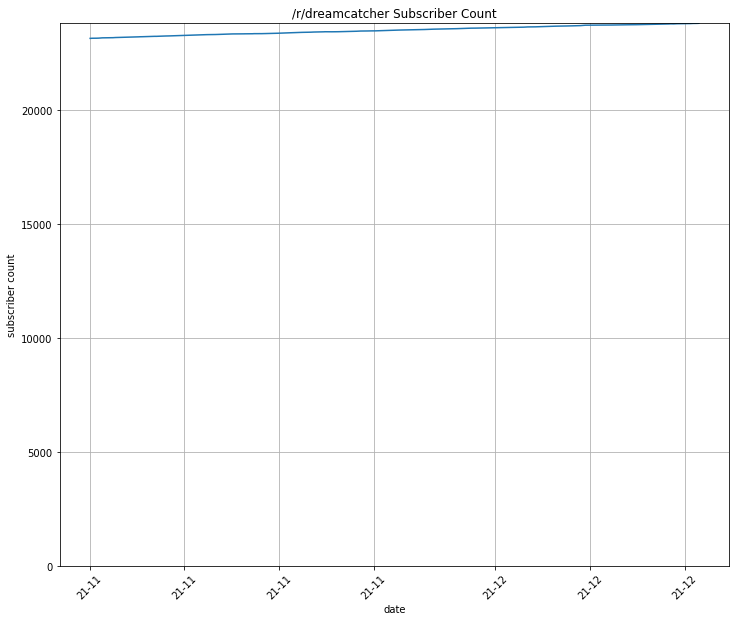

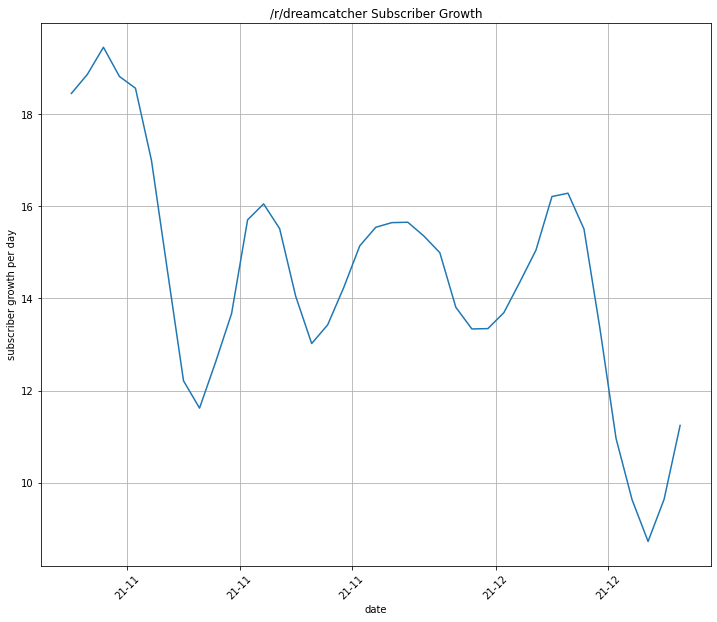

In [9]:
kernel_size = 7

# fix (interpolate) bad sub count data
timestamps = np.zeros(len(subcount_temp))
subs = np.zeros(len(subcount_temp))
no_sub_data_end = -1
temp = 0
for i, ts in enumerate(subcount_temp):
    timestamps[i] = ts
    subs[i] = subcount_temp[ts]
    if subs[i] == -1:
        no_sub_data_end = i
        
    # sanity check for large spikes because pushshift gave bad data
    elif temp != 0 and subs[i] < subs[temp] - 100:
        subs[temp] = (subs[i] + subs[i-2])/2
    temp = i
        
if start_subs is not None:
    if no_sub_data_end < len(subs)+1:
        subs[:no_sub_data_end+1] = np.floor(np.linspace(start_subs, subs[no_sub_data_end+1], no_sub_data_end+1))
        
start_epoch_date = datetime.datetime.fromtimestamp(start_epoch, tz=datetime.timezone.utc)
no_sub_data_end_date = datetime.datetime.fromtimestamp(timestamps[no_sub_data_end], tz=datetime.timezone.utc)


subcount = SortedDict()
for i, s in enumerate(subs):
    subcount[timestamps[i]] = s
# sub count
print(f"subs at start: {subs[0]}")
print(f"subs at end: {subs[-1]}")
        
dates = [datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in timestamps]
    
plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, subs)
plt.ylim(bottom=0)
# plt.axvspan(start_epoch_date, no_sub_data_end_date, color='red', alpha=0.25)
plt.xlabel('date')
plt.ylabel('subscriber count')
plt.title('/r/%s Subscriber Count' % (sub))
plt.grid(visible=True, which='both', axis='both')
plt.savefig('plots/01_sub_count.png', transparent=False)
plt.show()

# sub growth


ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

sub_growth_ts = []
sub_growth = []
while ts_end < end_epoch:
    it = subcount.irange(ts_begin, ts_end)
    temp_ts = []
    temp_subcount = []
    for ts in it:
        temp_ts.append(ts)
        temp_subcount.append(subcount[ts])
    if len(temp_ts) != 0:
        p_fit = np.polyfit(temp_ts, temp_subcount, 1)
        sub_growth_ts.append((ts_begin + ts_end)/2)
        sub_growth.append(p_fit[0])
    ts_begin += secs_in_day
    ts_end += secs_in_day

dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in sub_growth_ts])
sub_growth = np.array(sub_growth) * secs_in_day

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, sub_growth)
# plt.axvspan(start_epoch_date, no_sub_data_end_date, color='red', alpha=0.25)
plt.xlabel('date')
plt.ylabel('subscriber growth per day')
plt.title('/r/%s Subscriber Growth' % (sub))
plt.grid(visible=True, which='both', axis='both')

# for i,d in enumerate(dates):
#     if date_scream > d:
#         val_scream = sub_growth[i]
#     if date_boca > d:
#         val_boca = sub_growth[i]
#     if date_online_concert > d:
#         val_online_concert = sub_growth[i]
#     if date_seven_spirits > d:
#         val_seven_spirits = sub_growth[i]

# plt.annotate("Scream",
#              (date_scream,val_scream),
#              (-50, 50),
#              textcoords='offset points',
#              arrowprops={'arrowstyle': '->'})
# plt.annotate("Boca",
#              (date_boca,val_boca),
#              (-50, 50),
#              textcoords='offset points',
#              arrowprops={'arrowstyle': '->'})
# plt.annotate("Streaming Into The\nNight Online Concert",
#              (date_online_concert,val_online_concert),
#              (-50, 50),
#              textcoords='offset points',
#              arrowprops={'arrowstyle': '->'})
# plt.annotate("Seven Spirits\nOnline Concert",
#              (date_seven_spirits,val_seven_spirits),
#              (-50, 50),
#              textcoords='offset points',
#              arrowprops={'arrowstyle': '->'})

plt.savefig('plots/02_sub_growth.png')
plt.show()



### Post and Comment Frequency

/tmp/ipykernel_8657/3452056878.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both', axis='both')


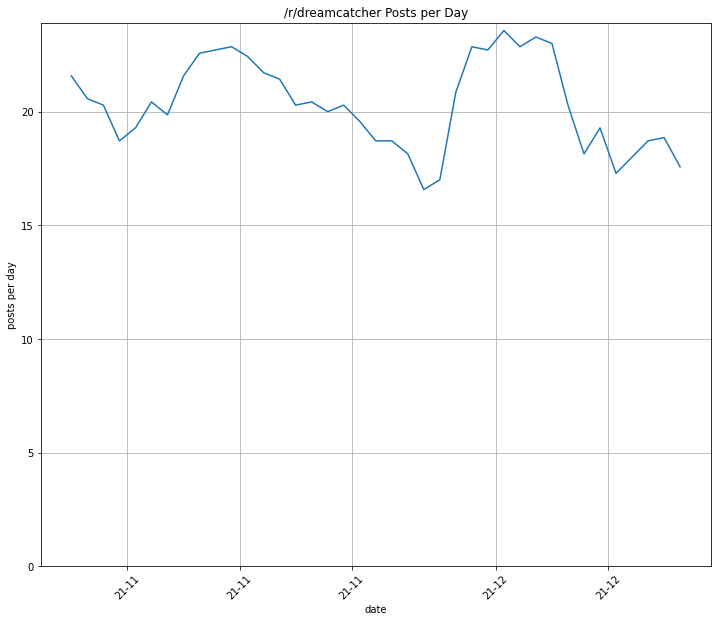

/tmp/ipykernel_8657/3452056878.py:115: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both', axis='both')


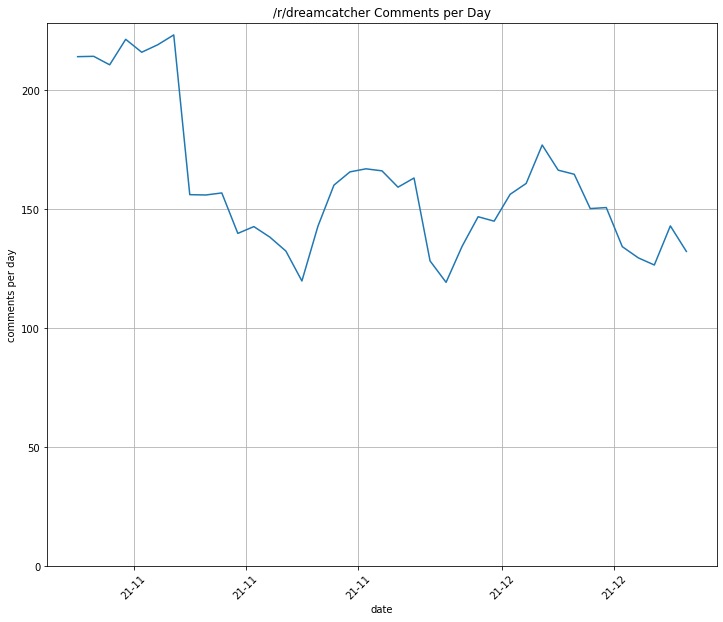

In [10]:
kernel_size = 7

# sort posts by time stamp
chron_posts = SortedDict()

for key, post in posts.items():
    chron_posts[post.ts] = post
    
    
# posts per day
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_freq_ts = []
post_freq = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    count = 0
    for ts in it:
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_freq_ts.append(ts)
        post_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in post_freq_ts])
post_freq = np.array(post_freq) / kernel_size

if len(post_freq) > 0:
    plt.figure(figsize=(12,10))
    plt.xticks(rotation=45)
    ax = plt.gca()
    xfmt = md.DateFormatter('%y-%m')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, post_freq)
    plt.ylim(bottom=0)
    plt.xlabel('date')
    plt.ylabel('posts per day')
    plt.title('/r/%s Posts per Day' % (sub))
    plt.grid(b=True, which='both', axis='both')
    
#     for i,d in enumerate(dates):
#         if date_scream > d:
#             val_scream = post_freq[i]
#         if date_boca > d:
#             val_boca = post_freq[i]
#         if date_online_concert > d:
#             val_online_concert = post_freq[i]
#         if date_seven_spirits > d:
#             val_seven_spirits = post_freq[i]

#     plt.annotate("Scream",
#                  (date_scream,val_scream),
#                  (-50, 50),
#                  textcoords='offset points',
#                  arrowprops={'arrowstyle': '->'})
#     plt.annotate("Boca",
#                  (date_boca,val_boca),
#                  (-50, 50),
#                  textcoords='offset points',
#                  arrowprops={'arrowstyle': '->'})
#     plt.annotate("Streaming Into The\nNight Online Concert",
#                  (date_online_concert,val_online_concert),
#                  (-50, 50),
#                  textcoords='offset points',
#                  arrowprops={'arrowstyle': '->'})
#     plt.annotate("Seven Spirits\nOnline Concert",
#                  (date_seven_spirits,val_seven_spirits),
#                  (-50, 100),
#                  textcoords='offset points',
#                  arrowprops={'arrowstyle': '->'})
plt.savefig('plots/03_posts_rate.png')
plt.show()


# comments per day
chron_comments = SortedDict()
for key, post in posts.items():
    for comment in post.comments:
        chron_comments[comment.ts] = comment

ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_freq_ts = []
comment_freq = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    count = 0
    for ts in it:
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_freq_ts.append(ts)
        comment_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in comment_freq_ts])
comment_freq = np.array(comment_freq) / kernel_size

if len(comment_freq) > 0:
    plt.figure(figsize=(12,10))
    plt.xticks(rotation=45)
    ax = plt.gca()
    xfmt = md.DateFormatter('%y-%m')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, comment_freq)
    plt.ylim(bottom=0)
    plt.xlabel('date')
    plt.ylabel('comments per day')
    plt.title('/r/%s Comments per Day' % (sub))
    plt.grid(b=True, which='both', axis='both')
    
#     for i,d in enumerate(dates):
#         if date_scream > d:
#             val_scream = comment_freq[i]
#         if date_boca > d:
#             val_boca = comment_freq[i]
#         if date_online_concert > d:
#             val_online_concert = comment_freq[i]
#         if date_seven_spirits > d:
#             val_seven_spirits = comment_freq[i]

#     plt.annotate("Scream",
#                  (date_scream,val_scream),
#                  (-50, 50),
#                  textcoords='offset points',
#                  arrowprops={'arrowstyle': '->'})
#     plt.annotate("Boca",
#                  (date_boca,val_boca),
#                  (-50, 50),
#                  textcoords='offset points',
#                  arrowprops={'arrowstyle': '->'})
#     plt.annotate("Streaming Into The\nNight Online Concert",
#                  (date_online_concert,val_online_concert),
#                  (-50, 50),
#                  textcoords='offset points',
#                  arrowprops={'arrowstyle': '->'})
#     plt.annotate("Seven Spirits\nOnline Concert",
#                  (date_seven_spirits,val_seven_spirits),
#                  (-50, 100),
#                  textcoords='offset points',
#                  arrowprops={'arrowstyle': '->'})
    
plt.savefig('plots/04_comments_rate.png')
plt.show()

In [11]:
# Make Score Adjustments

all_ts = np.zeros((len(chron_posts)))
all_scores = np.zeros((len(chron_posts)))

for i, ts in enumerate(chron_posts):
    all_ts[i] = ts - start_epoch
    all_scores[i] = chron_posts[ts].score
    
all_comment_ts = np.zeros((len(chron_comments)))
all_comment_scores = np.zeros((len(chron_comments)))

for i, ts in enumerate(chron_comments):
    all_comment_ts[i] = ts - start_epoch
    all_comment_scores[i] = chron_comments[ts].score
        
post_slope, post_int = np.polyfit(all_ts, all_scores, 1)
comment_slope, comment_int = np.polyfit(all_comment_ts, all_comment_scores, 1)

def calc_adj(ts, score):
    frac_time = (ts - start_epoch) / (end_epoch - start_epoch)
    scalar = score / (frac_time*(end_epoch-start_epoch)*post_slope+post_int)
    adj_score = (post_int+(end_epoch-start_epoch)*post_slope) * scalar
    return float(adj_score)
def calc_comment_adj(ts, score):
    frac_time = (ts - start_epoch) / (end_epoch - start_epoch)
    scalar = score / (frac_time*(end_epoch-start_epoch)*comment_slope+comment_int)
    adj_score = (comment_int+(end_epoch-start_epoch)*comment_slope) * scalar
    return float(adj_score)

### Average Post and Comment Scores

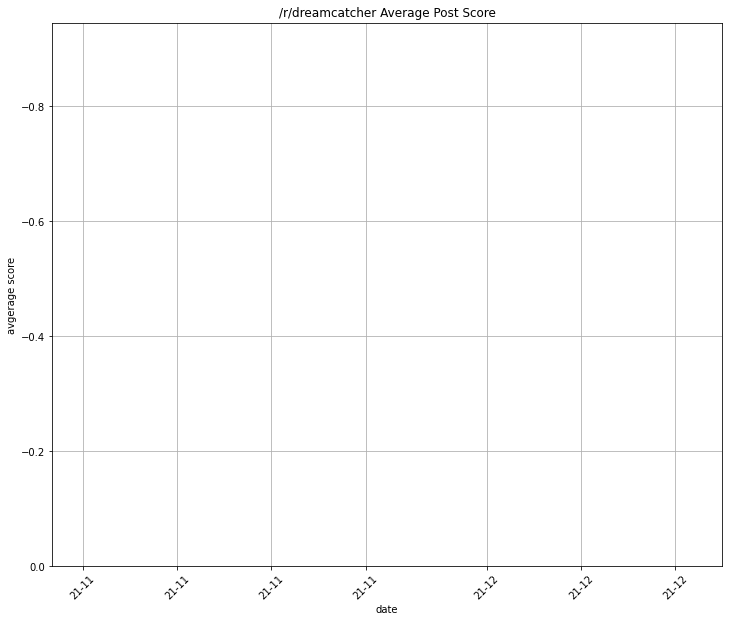

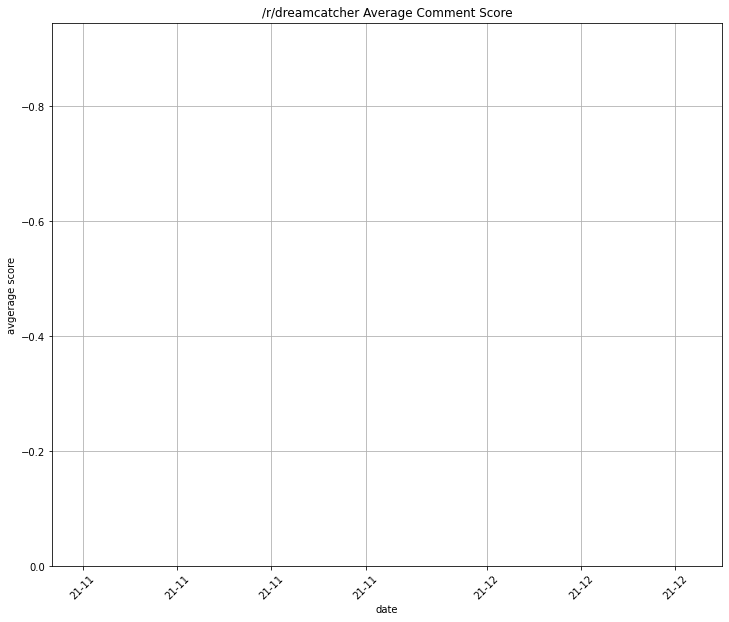

In [12]:
kernel_size = 7

# sort posts by time stamp
chron_posts = SortedDict()

for key, post in posts.items():
    chron_posts[post.ts] = post
    
# average post score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_score_ts = []
post_avg_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_score = 0
    count = 0
    for ts in it:
        total_score += chron_posts[ts].score
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_avg_score_ts.append(ts)
        post_avg_score.append(total_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in post_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_score)
plt.plot([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in [start_epoch, end_epoch]],
         [post_int, post_int+post_slope*(end_epoch-start_epoch)])
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage score')
plt.title('/r/%s Average Post Score' % (sub))
plt.grid(visible=True, which='both', axis='both')

plt.savefig('plots/05_avg_post_score.png')
plt.show()

# average comment score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_avg_score_ts = []
comment_avg_score = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    total_adj_comment_score = 0
    count = 0
    for ts in it:
        total_adj_comment_score += chron_comments[ts].score
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_avg_score_ts.append(ts)
        comment_avg_score.append(total_adj_comment_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in comment_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_avg_score)
plt.plot([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in [start_epoch, end_epoch]],
         [comment_int, comment_int+comment_slope*(end_epoch-start_epoch)])
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage score')
plt.title('/r/%s Average Comment Score' % (sub))
plt.grid(visible=True, which='both', axis='both')

plt.savefig('plots/06_avg_comment_score.png')
plt.show()

### Average Adjusted Post and Comment Scores

/tmp/ipykernel_8657/3363683802.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both', axis='both')


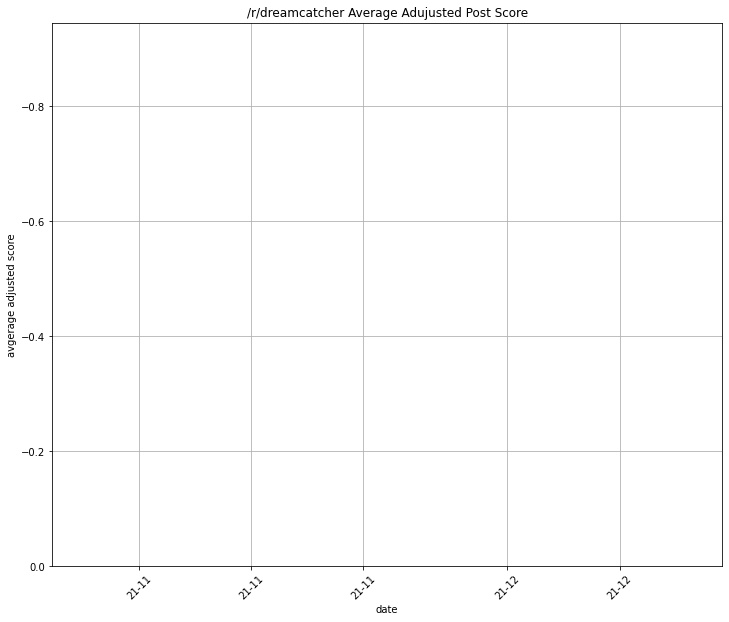

/tmp/ipykernel_8657/3363683802.py:70: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both', axis='both')


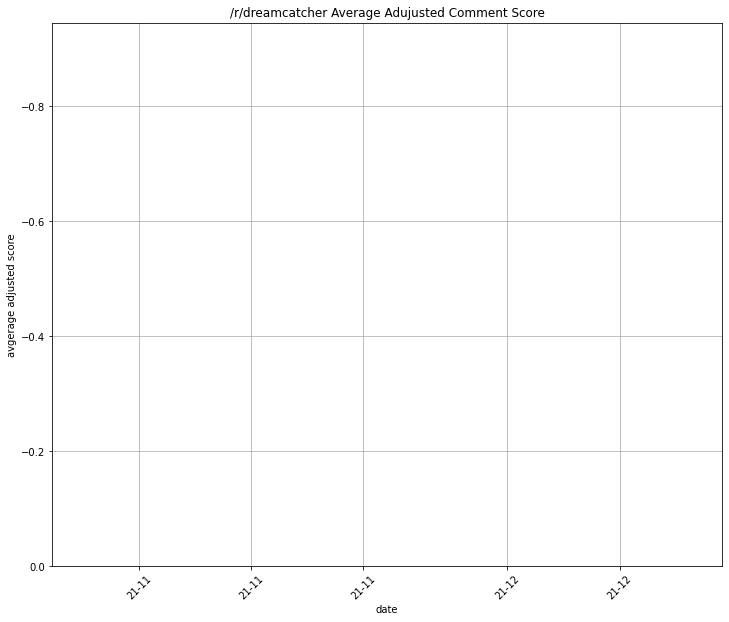

In [13]:
# average post score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_adj_score_ts = []
post_avg_adj_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_adj_score = 0
    count = 0
    for ts in it:
        total_adj_score += calc_adj(ts, chron_posts[ts].score)
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        post_avg_adj_score_ts.append(ts)
        post_avg_adj_score.append(total_adj_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in post_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_adj_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Post Score' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.savefig('plots/07_adj_post_score.png')
plt.show()

# average comment score
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

comment_avg_score_ts = []
comment_avg_score = []
while ts_end < end_epoch:
    it = chron_comments.irange(ts_begin, ts_end)
    total_adj_comment_score = 0
    count = 0
    for ts in it:
        total_adj_comment_score += calc_comment_adj(ts, chron_comments[ts].score)
        count += 1
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        comment_avg_score_ts.append(ts)
        comment_avg_score.append(total_adj_comment_score / count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in comment_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, comment_avg_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel('avgerage adjusted score')
plt.title('/r/%s Average Adujusted Comment Score' % (sub))
plt.grid(b=True, which='both', axis='both')

plt.savefig('plots/08_adj_comment_score.png')
plt.show()

## Leaderboards

### Top Posts

In [14]:
adj_scores = np.zeros((len(posts)), dtype=float)
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    adj_scores[i] = calc_adj(ts, post.score)

top_idx = (-adj_scores).argsort()[:10]

fmt = "| [{}]({}) | {} | {} | {} |"
fmts = []

posts_list = list(posts)
for i, idx in enumerate(top_idx):
    post = posts[posts_list[idx]]
    ts = int(post.ts)
    ts_str = datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    print('top post #%d' % (i+1))
    print('title:          %s' % (post.title))
    print('author:         %s' % (post.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (post.score))
    print('adjusted score: %f' % (calc_adj(post.ts, post.score)))
    print('comments:       %d' % (len(post.comments)))
    print('permalink:      https://www.reddit.com%s' % (post.permalink))
    fmts.append(fmt.format(
        word_truncate(md_table_friendly(post.title), 100),
        f'https://redd.it/{post.id}',
        f'u/{post.author}',
        round(post.score),
        round(calc_adj(post.ts, post.score))
    ))
    print()
    
for x in fmts:
    print(x)

top post #1
title:          Halloween Special: 5 K-pop groups that fit the ‘horror’ concept featuring Dreamcatcher and VIXX (Pinkvilla Article 211031)
author:         GI0VANNI_512
time:           2021-11-01 00:45:41
score:          -1
adjusted score: -1.000000
comments:       4
permalink:      https://www.reddit.com/r/dreamcatcher/comments/qk2pk1/halloween_special_5_kpop_groups_that_fit_the/

top post #2
title:          JiU
author:         JiU-noona
time:           2021-11-13 14:27:44
score:          -1
adjusted score: -1.000000
comments:       4
permalink:      https://www.reddit.com/r/dreamcatcher/comments/qt2d0a/jiu/

top post #3
title:          JiU - Thank you for being with us today❤️🥰 See you tomorrow❤️ Pictures taken by Ddua heh (211113 DC Weverse)
author:         nat1withadv
time:           2021-11-13 14:20:18
score:          -1
adjusted score: -1.000000
comments:       13
permalink:      https://www.reddit.com/r/dreamcatcher/comments/qt27ua/jiu_thank_you_for_being_with_us_toda

### Top Comments

In [15]:
all_comments = []
comment_ts2post_ts = None
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    for comment in post.comments:
        all_comments.append(comment)
#         if comment.ts not in comment_ts2post_ts:
#             comment_ts2post_ts[comment.ts] = ts

adj_scores = np.zeros((len(all_comments)), dtype=float)
for i, comment in enumerate(all_comments):
    ts = int(comment.ts)
    adj_scores[i] = calc_comment_adj(ts, comment.score)
    
top_idx = (-adj_scores).argsort()[:10]

fmt = "| [{}]({}) | {} | {} | {} |"
fmts = []

for i, idx in enumerate(top_idx):
    comment = all_comments[idx]
    body = comment.body.replace('\n', ' ')
    body = (body[:97] + '...') if len(body) > 97 else body
    ts = int(comment.ts)
    ts_str = datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    print('top comment #%d' % (i+1))
    print('comment:        %s' % (body))
    print('author:         %s' % (comment.author))
    print('time:           %s' % (ts_str))
    print('score:          %d' % (comment.score))
    print('adjusted score: %f' % (adj_scores[idx]))
    print('permalink:      https://www.reddit.com%s?context=10000' % (comment.permalink))
    print()
    fmts.append(fmt.format(
        word_truncate(md_table_friendly(remove_md_links(comment.body.replace("\n", " "))), 100),
        f'https://www.reddit.com{comment.permalink}?context=10000',
        f'u/{comment.author}',
        round(comment.score),
        round(adj_scores[idx])
    ))
    
for x in fmts:
    print(x)

top comment #1
comment:        Haha, I was actually still pretty ignorant about K-Pop back then. Came from a [metalcore](https:/...
author:         RustyIsBad
time:           2021-11-01 18:24:45
score:          -1
adjusted score: -1.000000
permalink:      https://www.reddit.com/r/dreamcatcher/comments/qk2pk1/halloween_special_5_kpop_groups_that_fit_the/hiwvaco/?context=10000

top comment #2
comment:        I wish the lightstick reacted to the concert tho
author:         StrawberryJellyBun
time:           2021-11-07 02:53:14
score:          -1
adjusted score: -1.000000
permalink:      https://www.reddit.com/r/dreamcatcher/comments/qof7z1/dreamcatcher_4th_online_concert_halloween/hjmq042/?context=10000

top comment #3
comment:        I've been waiting all day for this
author:         Nivracer
time:           2021-11-07 02:53:58
score:          -1
adjusted score: -1.000000
permalink:      https://www.reddit.com/r/dreamcatcher/comments/qof7z1/dreamcatcher_4th_online_concert_halloween/hjmq3

### Top Posters

In [16]:
users = OrderedDict()
for i, (key, post) in enumerate(posts.items()):
    ts = int(post.ts)
    if post.author == None:
        continue
    if post.author not in users:
        users[post.author] = {}
        users[post.author]['score'] = 0
        users[post.author]['adj_score'] = 0
        users[post.author]['posts'] = 0
        users[post.author]['comment_score'] = 0
        users[post.author]['adj_comment_score'] = 0
        users[post.author]['comments'] = 0
    users[post.author]['score'] += post.score
    users[post.author]['adj_score'] += calc_adj(ts, post.score)
    users[post.author]['posts'] += 1
    for comment in post.comments:
        if comment.author not in users:
            users[comment.author] = {}
            users[comment.author]['score'] = 0
            users[comment.author]['adj_score'] = 0
            users[comment.author]['posts'] = 0
            users[comment.author]['comment_score'] = 0
            users[comment.author]['adj_comment_score'] = 0
            users[comment.author]['comments'] = 0
        users[comment.author]['comment_score'] += comment.score
        users[comment.author]['adj_comment_score'] += calc_comment_adj(comment.ts, comment.score)
        users[comment.author]['comments'] += 1

In [17]:
sorted_posters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_score'], reverse=True))

fmt = "| {} | {} | {} | {} |"
fmts = []

for i, key in enumerate(sorted_posters):
    if i >= 10:
        break
    print('top poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('total number of posts: %d' % (sorted_posters[key]['posts']))
    print('total score:           %d' % (sorted_posters[key]['score']))
    print('total adjusted score:  %f' % (sorted_posters[key]['adj_score']))
    print()
    
    fmts.append(fmt.format(
        f'u/{key}',
        sorted_posters[key]['posts'],
        round(sorted_posters[key]['score']),
        round(sorted_posters[key]['adj_score']),
    ))
    
for x in fmts:
    print(x)

top poster #1
user:                  mekagojira74
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #2
user:                  lostknight0727
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #3
user:                  Patxi_Jamison
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #4
user:                  splcgr32
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #5
user:                  enzodesune
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #6
user:                  ipwnmice
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #7
user:                  Ice6Star
total number of posts: 0
total score:           0
total adjusted score:  0.000000

top poster #8
user:                  While-Secret
total number of posts: 0
total

### Top Commenters

In [18]:
sorted_commenters = OrderedDict(sorted(users.items(), key=lambda x: x[1]['adj_comment_score'], reverse=True))

fmt = "| {} | {} | {} | {} |"
fmts = []

for i, key in enumerate(sorted_commenters):
    if i >= 10:
        break
    print('top commenter #%d' % (i+1))
    print('user:                          %s' % (key))
    print('total number of comments:      %d' % (sorted_commenters[key]['comments']))
    print('total comment score:           %d' % (sorted_commenters[key]['comment_score']))
    print('total adjusted comment score:  %f' % (sorted_commenters[key]['adj_comment_score']))
    print()
    fmts.append(fmt.format(
        f'u/{key}',
        sorted_commenters[key]['comments'],
        round(sorted_commenters[key]['comment_score']),
        round(sorted_commenters[key]['adj_comment_score']),
    ))
    
for x in fmts:
    print(x)

top commenter #1
user:                          theboyfromthewell
total number of comments:      0
total comment score:           0
total adjusted comment score:  0.000000

top commenter #2
user:                          Winter_foxxx
total number of comments:      0
total comment score:           0
total adjusted comment score:  0.000000

top commenter #3
user:                          rscape5910
total number of comments:      0
total comment score:           0
total adjusted comment score:  0.000000

top commenter #4
user:                          J0SHUA2021
total number of comments:      0
total comment score:           0
total adjusted comment score:  0.000000

top commenter #5
user:                          AutoModerator
total number of comments:      0
total comment score:           0
total adjusted comment score:  0.000000

top commenter #6
user:                          nevermeltmoon
total number of comments:      0
total comment score:           0
total adjusted comment score: 


## Top Average Users

In [19]:
temp = OrderedDict()
for user in users:
    if user not in temp:
        temp[user] = {}
        
    if users[user]['posts'] == 0:
        temp[user]['avg_adj_score'] = 0;
    else:
        temp[user]['avg_adj_score'] = users[user]['adj_score'] / users[user]['posts']
        
    if users[user]['comments'] == 0:
        temp[user]['avg_adj_comment_score'] = 0;
    else:
        temp[user]['avg_adj_comment_score'] = users[user]['adj_comment_score'] / users[user]['comments']


In [20]:
sorted_avg_posters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_score'], reverse=True))

i = 0;
for key in sorted_avg_posters:
    if i >= 10:
        break
    if users[key]['posts'] < 10:
        continue
    print('top avg poster #%d' % (i+1))
    print('user:                  %s' % (key))
    print('avg adjusted score:    %f' % (sorted_avg_posters[key]['avg_adj_score']))
    print('total number of posts: %d' % (users[key]['posts']))
    print('total score:           %d' % (users[key]['score']))
    print('total adjusted score:  %f' % (users[key]['adj_score']))
    print()
    i += 1

top avg poster #1
user:                  HarryMinji37
avg adjusted score:    -1.000000
total number of posts: 12
total score:           -12
total adjusted score:  -12.000000

top avg poster #2
user:                  MetallicCats
avg adjusted score:    -1.000000
total number of posts: 73
total score:           -73
total adjusted score:  -73.000000

top avg poster #3
user:                  SpideyCyclist
avg adjusted score:    -1.000000
total number of posts: 205
total score:           -205
total adjusted score:  -205.000000

top avg poster #4
user:                  JiU-noona
avg adjusted score:    -1.000000
total number of posts: 44
total score:           -44
total adjusted score:  -44.000000

top avg poster #5
user:                  Rizzkyy
avg adjusted score:    -1.000000
total number of posts: 63
total score:           -63
total adjusted score:  -63.000000

top avg poster #6
user:                  GI0VANNI_512
avg adjusted score:    -1.000000
total number of posts: 42
total score:    

In [21]:
sorted_avg_commenters = OrderedDict(sorted(temp.items(), key=lambda x: x[1]['avg_adj_comment_score'], reverse=True))

i = 0
for key in sorted_avg_commenters:
    if i >= 10:
        break
    if users[key]['comments'] < 30:
        continue
    print('top avg commenter #%d' % (i+1))
    print('user:                         %s' % (key))
    print('avg adjusted comment score:   %f' % (sorted_avg_commenters[key]['avg_adj_comment_score']))
    print('total number of comments:     %d' % (users[key]['comments']))
    print('total comment score:          %d' % (users[key]['comment_score']))
    print('total adjusted comment score: %f' % (users[key]['adj_comment_score']))
    print()
    i += 1

top avg commenter #1
user:                         Snoo_58309
avg adjusted comment score:   -1.000000
total number of comments:     80
total comment score:          -80
total adjusted comment score: -80.000000

top avg commenter #2
user:                         CapitanNoob
avg adjusted comment score:   -1.000000
total number of comments:     67
total comment score:          -67
total adjusted comment score: -67.000000

top avg commenter #3
user:                         lostknight0727
avg adjusted comment score:   -1.000000
total number of comments:     72
total comment score:          -72
total adjusted comment score: -72.000000

top avg commenter #4
user:                         MetallicCats
avg adjusted comment score:   -1.000000
total number of comments:     104
total comment score:          -104
total adjusted comment score: -104.000000

top avg commenter #5
user:                         SpideyCyclist
avg adjusted comment score:   -1.000000
total number of comments:     385
total c

## Posts and Comments with Reddit awards

### Posts

In [22]:
# sort posts by time stamp
chron_posts = SortedDict()

for key, post in posts.items():
    chron_posts[post.ts] = post
    
gilded_users = {}

fmt = "| [{}]({}) | {} |"
p_fmts = []
g_fmts = []
s_fmts = []

print("Platinums:")
for post in chron_posts.items():
    if 'gid_3' in post[1].gildings:
        print(f"title:     {post[1].title}")
        print(f"author:    {post[1].author}")
        print(f"permalink: https://www.reddit.com{post[1].permalink}")
        print()
        if post[1].author not in gilded_users:
            gilded_users[post[1].author] = (0, 0, 0)
        temp = gilded_users[post[1].author]
        gilded_users[post[1].author] = (temp[0] + post[1].gildings['gid_3'], temp[1], temp[2])
        p_fmts.append(fmt.format(
            word_truncate(md_table_friendly(post[1].title), 100),
            f'https://redd.it/{post[1].id}',
            f'u/{post[1].author}',
        ))
        
print("\n\nGolds:")
for post in chron_posts.items():
    if 'gid_2' in post[1].gildings:
        print(f"title:     {post[1].title}")
        print(f"author:    {post[1].author}")
        print(f"permalink: https://www.reddit.com{post[1].permalink}")
        print()
        if post[1].author not in gilded_users:
            gilded_users[post[1].author] = (0, 0, 0)
        temp = gilded_users[post[1].author]
        gilded_users[post[1].author] = (temp[0], temp[1] + post[1].gildings['gid_2'], temp[2])
        g_fmts.append(fmt.format(
            word_truncate(md_table_friendly(post[1].title), 100),
            f'https://redd.it/{post[1].id}',
            f'u/{post[1].author}',
        ))
        
print("\n\nSilvers:")
for post in chron_posts.items():
    if 'gid_1' in post[1].gildings:
        print(f"title:     {post[1].title}")
        print(f"author:    {post[1].author}")
        print(f"permalink: https://www.reddit.com{post[1].permalink}")
        print()
        if post[1].author not in gilded_users:
            gilded_users[post[1].author] = (0, 0, 0)
        temp = gilded_users[post[1].author]
        gilded_users[post[1].author] = (temp[0], temp[1], temp[2] + post[1].gildings['gid_1'])
        s_fmts.append(fmt.format(
            word_truncate(md_table_friendly(post[1].title), 100),
            f'https://redd.it/{post[1].id}',
            f'u/{post[1].author}',
        ))
        
print("\n\nplats")
print(len(p_fmts))
for x in p_fmts:
    print(x)

print("\n\ngolds")
print(len(g_fmts))
for x in g_fmts:
    print(x)

print("\n\nsilvers")
print(len(s_fmts))
for x in s_fmts:
    print(x)

Platinums:


Golds:
title:     Don't Blink! (Plaster Figure Sua Ver.)
author:    SpideyCyclist
permalink: https://www.reddit.com/r/dreamcatcher/comments/reatkk/dont_blink_plaster_figure_sua_ver/



Silvers:
title:     Trick or Treat🎃 🎃 🎃
author:    HarryMinji37
permalink: https://www.reddit.com/r/dreamcatcher/comments/qk5sui/trick_or_treat/

title:     LOONA's Yves mentioned that she was supposed to meet Dami at her studio, but couldn't because of her scheduled V Live + talks about how they are the same age and how their friendship is precious (211101 LOONA V Live)
author:    nat1withadv
permalink: https://www.reddit.com/r/dreamcatcher/comments/qkc926/loonas_yves_mentioned_that_she_was_supposed_to/

title:     Hwang Sooyeon introduces herself as the performance director for Dreamcatcher (211101)
author:    SpideyCyclist
permalink: https://www.reddit.com/r/dreamcatcher/comments/qkfogx/hwang_sooyeon_introduces_herself_as_the/

title:     A painting of Jiu that was supposed to be a Hallow

### Comments

In [23]:
chron_comments = SortedDict()
for key, post in posts.items():
    for comment in post.comments:
        chron_comments[comment.ts] = comment
        
fmt = "| [{}]({}) | {} |"
p_fmts = []
g_fmts = []
s_fmts = []

print("Platinums:")
for ts,comment in chron_comments.items():
    if 'gid_3' in comment.gildings:
        body = (comment.body[:97] + '...') if len(comment.body) > 97 else comment.body
        print(f"comment:   {body}")
        print(f"author:    {comment.author}")
        print(f"permalink: https://www.reddit.com{comment.permalink}?context=10000")
        print()
        if comment.author not in gilded_users:
            gilded_users[comment.author] = (0, 0, 0)
        temp = gilded_users[comment.author]
        gilded_users[comment.author] = (temp[0] + comment.gildings['gid_3'], temp[1], temp[2])
        p_fmts.append(fmt.format(
            word_truncate(md_table_friendly(remove_md_links(comment.body)), 100),
            f'https://www.reddit.com{comment.permalink}?context=10000',
            f'u/{comment.author}',
        ))
        
print("\n\nGolds:")
for ts,comment in chron_comments.items():
    if 'gid_2' in comment.gildings:
        body = (comment.body[:97] + '...') if len(comment.body) > 97 else comment.body
        print(f"comment:   {body}")
        print(f"author:    {comment.author}")
        print(f"permalink: https://www.reddit.com{comment.permalink}?context=10000")
        print()
        if comment.author not in gilded_users:
            gilded_users[comment.author] = (0, 0, 0)
        temp = gilded_users[comment.author]
        gilded_users[comment.author] = (temp[0], temp[1] + comment.gildings['gid_2'], temp[2])
        g_fmts.append(fmt.format(
            word_truncate(md_table_friendly(remove_md_links(comment.body)), 100),
            f'https://www.reddit.com{comment.permalink}?context=10000',
            f'u/{comment.author}',
        ))
        
print("\n\nSilvers:")
for ts,comment in chron_comments.items():
    if 'gid_1' in comment.gildings:
        body = (comment.body[:97] + '...') if len(comment.body) > 97 else comment.body
        print(f"comment:   {body}")
        print(f"author:    {comment.author}")
        print(f"permalink: https://www.reddit.com{comment.permalink}?context=10000")
        print()
        if comment.author not in gilded_users:
            gilded_users[comment.author] = (0, 0, 0)
        temp = gilded_users[comment.author]
        gilded_users[comment.author] = (temp[0], temp[1], temp[2] + comment.gildings['gid_1'])
        s_fmts.append(fmt.format(
            word_truncate(md_table_friendly(remove_md_links(comment.body)), 100),
            f'https://www.reddit.com{comment.permalink}?context=10000',
            f'u/{comment.author}',
        ))
        
print("\n\nplats")
print(len(p_fmts))
for x in p_fmts:
    print(x)

print("\n\ngolds")
print(len(g_fmts))
for x in g_fmts:
    print(x)

print("\n\nsilvers")
print(len(s_fmts))
for x in s_fmts:
    print(x)

Platinums:


Golds:


Silvers:
comment:   I think they could pull it off well! It might be fun if they did a cute b-side music video or som...
author:    leokunni
permalink: https://www.reddit.com/r/dreamcatcher/comments/r06ze2/thoughts_on_a_cute_concept_with_a_twist/hlqphyb/?context=10000



plats
0


golds
0


silvers
1
| [I think they could pull it off well! It might be fun if they did a cute b-side music video or…](https://www.reddit.com/r/dreamcatcher/comments/r06ze2/thoughts_on_a_cute_concept_with_a_twist/hlqphyb/?context=10000) | u/leokunni |


### Most gilded users

In [24]:
def tot_award_value(x):
    return 1800*x[0] + 500*x[1] + 100*x[2]

temp = reversed(sorted(list(gilded_users.items()), key=lambda x: tot_award_value(x[1])))

fmt = "| {} | {} | {} | {} | {} |"
fmts = []

print(f"User                 \tplats\tgolds\tsilvers\ttotal_value")
for user, (p,g,s) in temp:
    print(f"{str(user):20}\t{p}\t{g}\t{s}\t{tot_award_value((p,g,s))}")
    fmts.append(fmt.format(
        f'u/{str(user)}',
        p,
        g,
        s,
        tot_award_value((p,g,s))
    ))

for x in fmts[:10]:
    print(x)

User                 	plats	golds	silvers	total_value
SpideyCyclist       	0	1	41	4600
nat1withadv         	0	0	43	4300
JiU-noona           	0	0	26	2600
Rizzkyy             	0	0	22	2200
abables             	0	0	13	1300
GI0VANNI_512        	0	0	12	1200
MetallicCats        	0	0	11	1100
Wilburg_1           	0	0	9	900
MeeloIsTrying       	0	0	7	700
StaySomnie          	0	0	5	500
vmca12              	0	0	4	400
borisartworks       	0	0	4	400
Pessimisticbobo     	0	0	4	400
Drone9315           	0	0	3	300
RobEthereal         	0	0	3	300
The_Ranger99        	0	0	2	200
spitfyre24          	0	0	2	200
skarnal87           	0	0	2	200
HarryMinji37        	0	0	2	200
leokunni            	0	0	1	100
dresdenologist      	0	0	1	100
seekgermangf        	0	0	1	100
sambot863           	0	0	1	100
Dalylllama          	0	0	1	100
Emotional_Lie_692   	0	0	1	100
niclaswwe           	0	0	1	100
copHerBoom          	0	0	1	100
Artistic_Sort_7041  	0	0	1	100
depressedkiterunner 	0	0	1	100
cutallone           	0	0	1	100
Sn

## Submission flair distribution

/tmp/ipykernel_8657/1631058633.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis='x')


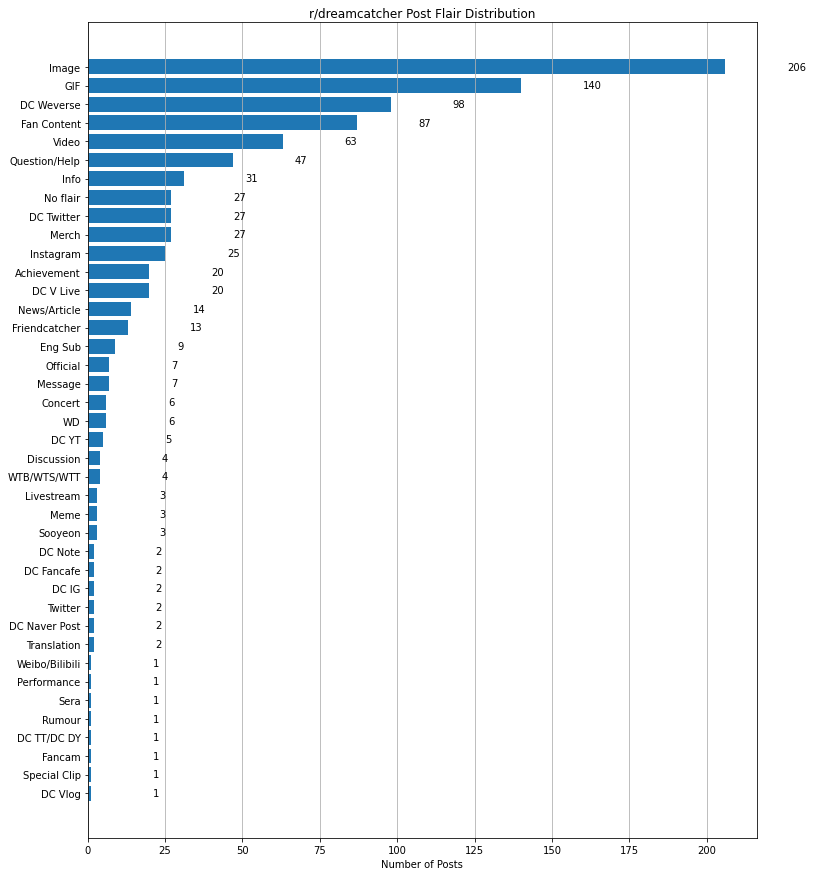

[('Image', 206), ('GIF', 140), ('DC Weverse', 98), ('Fan Content', 87), ('Video', 63), ('Question/Help', 47), ('Info', 31), ('Merch', 27), ('DC Twitter', 27), ('No flair', 27), ('Instagram', 25), ('DC V Live', 20), ('Achievement', 20), ('News/Article', 14), ('Friendcatcher', 13), ('Eng Sub', 9), ('Message', 7), ('Official', 7), ('WD', 6), ('Concert', 6), ('DC YT', 5), ('WTB/WTS/WTT', 4), ('Discussion', 4), ('Sooyeon', 3), ('Meme', 3), ('Livestream', 3), ('Translation', 2), ('DC Naver Post', 2), ('Twitter', 2), ('DC IG', 2), ('DC Fancafe', 2), ('DC Note', 2), ('DC Vlog', 1), ('Special Clip', 1), ('Fancam', 1), ('DC TT/DC DY', 1), ('Rumour', 1), ('Sera', 1), ('Performance', 1), ('Weibo/Bilibili', 1)]
total posts: 922


In [25]:
flairs = {}
for post in posts.items():
    if post[1].author is None or post[1].selftext == '[removed]':
        continue
    if post[1].link_flair is None:
        if 'No flair' not in flairs:
            flairs['No flair'] = 0
        flairs['No flair'] += 1
    else:
        if post[1].link_flair not in flairs:
            flairs[post[1].link_flair] = 0
        flairs[post[1].link_flair] += 1

flairs_chart = []
nums_chart = []
for flair,num in sorted(flairs.items(), key=lambda x: x[1]):
    flairs_chart.append(flair)
    nums_chart.append(num)

plt.figure(figsize=(12,15))
plt.barh(flairs_chart, nums_chart)
ax = plt.gca()
for i,v in enumerate(nums_chart):
    ax.text(v + 20, i, str(v), va='center')
plt.grid(b=True, axis='x')
plt.title(f"r/{sub} Post Flair Distribution")
plt.xlabel("Number of Posts")
plt.savefig('plots/09_post_flair_dist.png')
plt.show()

print(sorted(flairs.items(), key=lambda x: -x[1]))

print(f'total posts: {sum([x[1] for x in flairs.items()])}')

/tmp/ipykernel_8657/3653893652.py:49: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both', axis='both')


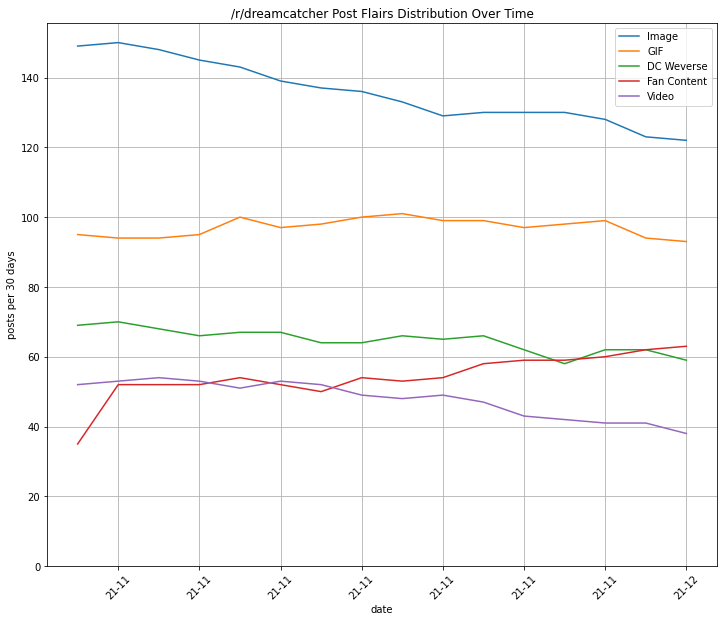

In [26]:
num_flair_types = 5

flairs_2 = [x[0] for x in sorted(flairs.items(), key=lambda x: -x[1])[:num_flair_types]]
flairs_time = []
for flair in flairs_2:
    flairs_time.append([])

kernel_size = 30

# sort posts by time stamp
chron_posts = SortedDict()

for key, post in posts.items():
    chron_posts[post.ts] = post
    

ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

post_avg_score_ts = []
post_avg_score = []
while ts_end < end_epoch:
    it = chron_posts.irange(ts_begin, ts_end)
    total_scores = [0] * num_flair_types
    for ts in it:
        try:
            idx = flairs_2.index(chron_posts[ts].link_flair)
        except ValueError:
            continue
        total_scores[idx] += 1
    ts = (ts_begin + ts_end) / 2
    post_avg_score_ts.append(ts)
    post_avg_score.append(total_scores)
    ts_begin += secs_in_day
    ts_end += secs_in_day

dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in post_avg_score_ts])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
plt.plot(dates, post_avg_score)
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel(f'posts per {kernel_size} days')
plt.title('/r/%s Post Flairs Distribution Over Time' % (sub))
plt.grid(b=True, which='both', axis='both')
plt.legend(flairs_2)
plt.savefig('plots/10_post_flair_dist_time.png')
plt.show()

## Member mention distribution

/tmp/ipykernel_8657/866541190.py:69: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis='x')


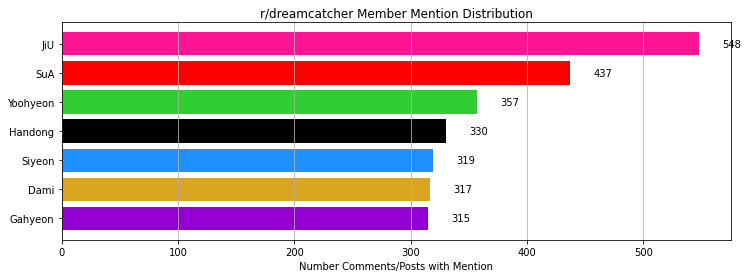

[('JiU', 548), ('SuA', 437), ('Yoohyeon', 357), ('Handong', 330), ('Siyeon', 319), ('Dami', 317), ('Gahyeon', 315)]


/tmp/ipykernel_8657/866541190.py:112: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both', axis='both')


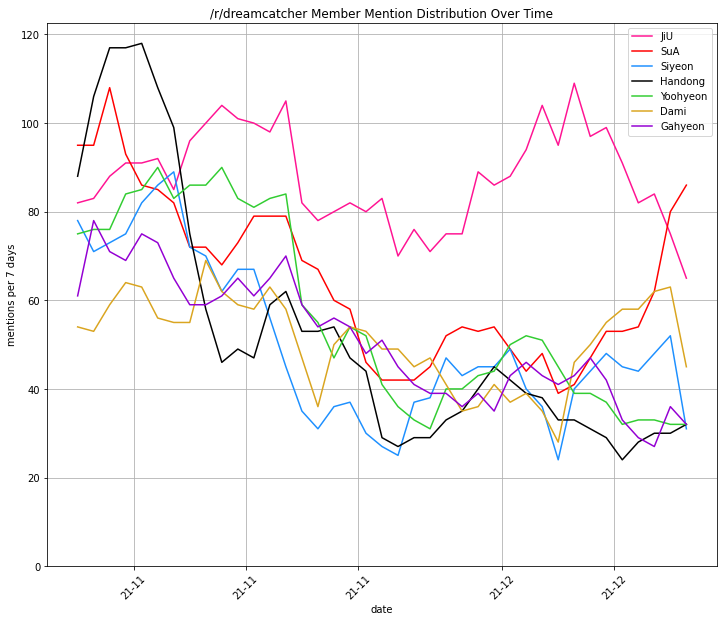

In [27]:
member_names = {
    'JiU': ['jiu', 'minji', 'lily', 'jyu', '지유', '민지'],
    'SuA': ['sua', 'bora', 'alice', 'swa', '수아', '보라'],
    'Siyeon': ['siyeon', 'monica', 'singnie', '시연'],
    'Handong': ['handong', 'della', 'dong', 'dongie', 'dongdong', '한동', '韩东', '韓東'],
    'Yoohyeon': ['yoohyeon', 'yoo', 'rachel', '유현'],
    'Dami': ['dami', 'yoobin', 'yubin', 'emma', '다미', '유빈'],
    'Gahyeon': ['gahyeon', 'lucy', 'gahyeonnie', 'gahyeonie', 'gah', '가현']
}
members = ['JiU', 'SuA', 'Siyeon', 'Handong', 'Yoohyeon', 'Dami', 'Gahyeon']
member_colors = {
    'JiU': '#FF1493',
    'SuA': '#FF0000',
    'Siyeon': '#1E90FF',
    'Handong': '#000000',
    'Yoohyeon': '#32CD32',
    'Dami': '#DAA520',
    'Gahyeon': '#9400D3',
}

# compile regexes for all nicknames
member_names_regexes = {}
for member in member_names:
    member_names_regexes[member] = [regex.compile(r"\b"+name+r"\b", flags=regex.IGNORECASE) for name in member_names[member]]

chron = SortedDict()
    
member_mentions = defaultdict(lambda: 0)

# search comments
for comment in all_comments:
    for member in member_names:
        for r in member_names_regexes[member]:
            if r.search(comment.body) is not None:
                member_mentions[member] += 1
                if (comment.ts, member) not in chron:
                    chron[(comment.ts, member)] = 0
                chron[(comment.ts, member)] += 1
#                 if member == 'Siyeon' and comment.ts > 1580515200 and comment.ts < 1581120000:
#                     print(f'comment: https://reddit.com/{comment.permalink}')
                break

# search post titles and selftexts
for post in posts.items():
    for member in member_names:
        for r in member_names_regexes[member]:
            if r.search(post[1].title) is not None or r.search(post[1].selftext) is not None:
                member_mentions[member] += 1
                if (post[1].ts, member) not in chron:
                    chron[(post[1].ts, member)] = 0
                chron[(post[1].ts, member)] += 1
#                 if member == 'Siyeon' and post[1].ts > 1580515200 and post[1].ts < 1581120000:
#                     print(f'post: https://reddit.com/{post[1].permalink}')
                break

# generate chart by most mentioned
members_chart = []
nums_chart = []
for member,num in sorted(member_mentions.items(), key=lambda x: x[1]):
    members_chart.append(member)
    nums_chart.append(num)
    
plt.figure(figsize=(12,4))
ax = plt.gca()
for i in range(len(members_chart)):
    plt.barh(members_chart[i], nums_chart[i], color=member_colors[members_chart[i]])
for i,v in enumerate(nums_chart):
    ax.text(v + 20, i, str(v), va='center')
plt.grid(b=True, axis='x')
plt.title(f"r/{sub} Member Mention Distribution")
plt.xlabel("Number Comments/Posts with Mention")
plt.savefig('plots/11_member_mention_dist.png')
plt.show()

print(sorted(member_mentions.items(), key=lambda x: -x[1]))

kernel_size = 7
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

timestamps = []
mentions = []
while ts_end < end_epoch:
    mentions.append([0 for _ in members])
    for i,member in enumerate(members):
        it = chron.irange((ts_begin, member), (ts_end, member))
        temp = list(it)
        total_mentions = 0
        for k in filter(lambda k: k[1] == member, temp):
            ts,_ = k
            if (ts, member) in temp:
                mentions[-1][i] += chron[(ts,member)]
    ts = (ts_begin + ts_end) / 2
    timestamps.append(ts)
    ts_begin += secs_in_day
    ts_end += secs_in_day

dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in timestamps])

plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
ax = plt.gca()
xfmt = md.DateFormatter('%y-%m')
ax.xaxis.set_major_formatter(xfmt)
mentions = list(map(list, zip(*mentions)))
for i in range(len(mentions)):
    plt.plot(dates, mentions[i], color=member_colors[members[i]])
plt.ylim(bottom=0)
plt.xlabel('date')
plt.ylabel(f'mentions per {kernel_size} days')
plt.title('/r/%s Member Mention Distribution Over Time' % (sub))
plt.grid(b=True, which='both', axis='both')
plt.legend(members)

plt.annotate("Yoohyeon\nbirthday",
             (date_yh_bd,140),
             (datetime.date.fromisoformat('2019-12-20'),160),
             arrowprops={'arrowstyle': '->'})
plt.annotate("Siyeon Paradise",
             (date_paradise,210),
             (datetime.date.fromisoformat('2019-12-25'),230),
             arrowprops={'arrowstyle': '->'})
plt.annotate("JiU birthday",
             (date_ju_bd,225),
             (datetime.date.fromisoformat('2020-05-05'),240),
             arrowprops={'arrowstyle': '->'})
plt.annotate("YWY2 ep01",
             (datetime.date.fromisoformat('2020-03-12'),160),
             (datetime.date.fromisoformat('2020-03-02'),240),
             arrowprops={'arrowstyle': '->'})
plt.annotate("Handong birthday",
             (date_hd_bd,225),
             (datetime.date.fromisoformat('2020-04-01'),260),
             arrowprops={'arrowstyle': '->'})
plt.annotate("YWY2\nHandong\neliminated",
             (datetime.date.fromisoformat('2020-05-02'),170),
             (datetime.date.fromisoformat('2020-04-05'),200),
             arrowprops={'arrowstyle': '->'})
plt.annotate("Siyeon birthday",
             (date_sy_bd,240),
             (datetime.date.fromisoformat('2020-09-15'),265),
             arrowprops={'arrowstyle': '->'})
plt.annotate("Scream",
             (date_scream,240),
             (datetime.date.fromisoformat('2020-01-30'),260),
             arrowprops={'arrowstyle': '->'})
plt.annotate("Boca",
             (date_boca,340),
             (datetime.date.fromisoformat('2020-07-05'),320),
             arrowprops={'arrowstyle': '->'})
# plt.annotate("Endless Night",
#              (datetime.datetime.fromtimestamp(1583280000),320),
#              (datetime.datetime.fromtimestamp(1583280000),410),
#              arrowprops={'arrowstyle': '->'})
plt.annotate("Streaming into\nthe Night concert",
             (date_online_concert,245),
             (datetime.date.fromisoformat('2020-06-15'),280),
             arrowprops={'arrowstyle': '->'})
plt.annotate("Seven Spirits\nconcert",
             (date_seven_spirits, 215),
             (datetime.date.fromisoformat('2020-11-15'),230),
             arrowprops={'arrowstyle': '->'})
# plt.annotate("SuA x CLC Seungyeon\nTadow Cover",
#              (datetime.datetime.fromtimestamp(1608249600),380),
#              (datetime.datetime.fromtimestamp(1605139200),500),
#              arrowprops={'arrowstyle': '->'})
plt.annotate("Handong\nleaves\nquarantine",
             (datetime.date.fromisoformat('2020-10-16'),200),
             (datetime.date.fromisoformat('2020-10-06'),220),
             arrowprops={'arrowstyle': '->'})
plt.annotate("r/dc bias\ndiscussions",
             (datetime.date.fromisoformat('2020-12-14'),180),
             (datetime.date.fromisoformat('2020-12-01'),200),
             arrowprops={'arrowstyle': '->'})
plt.savefig('plots/12_member_mention_dist_time.png')
plt.show()

## Mentions of r/dreamcatcher

In [28]:
rkpop_mentions = api_ps_praw.search_comments(after=start_epoch,
                                  before=end_epoch,
                                  subreddit='kpop',
                                  q=f'"r/{sub}"',
                                  limit=max_posts)
rkpop_count = 0
for k in rkpop_mentions:
    rkpop_count += 1

reddit_mentions = api_ps_praw.search_comments(after=start_epoch,
                                  before=end_epoch,
                                  subreddit=f'!{sub}',
                                  q=f'"r/{sub}"',
                                  limit=max_posts)
reddit_count = 0
reddit_mentions_dict = {}
for k in reddit_mentions:
    if k.subreddit not in reddit_mentions_dict:
        reddit_mentions_dict[k.subreddit] = 0
    reddit_mentions_dict[k.subreddit] += 1
    reddit_count += 1

print(f'Mentions of r/{sub} in r/kpop: {rkpop_count}')
print(f'Mentions of r/{sub} on reddit: {reddit_count}')
print(sorted(reddit_mentions_dict.items(), key=lambda x: -x[1]))

Mentions of r/dreamcatcher in r/kpop: 0
Mentions of r/dreamcatcher on reddit: 9
[(Subreddit(display_name='GFRIEND'), 4), (Subreddit(display_name='asiangirlsbeingcute'), 2), (Subreddit(display_name='memecatcher'), 1), (Subreddit(display_name='Music'), 1), (Subreddit(display_name='kpoprants'), 1)]


## Top video links

### Gfycat and Streamable

In [29]:
regex_str = r'(streamable\.com\/[a-zA-Z0-9]+)|(gfycat\.com\/\w+)'

gfy_streamable_links = {}

for comment in all_comments:
    x = re.findall(regex_str, comment.body, re.IGNORECASE)

    if len(x) != 0:
        for groups in x:
            for link in groups:
                if link == '':
                    continue
                if link not in gfy_streamable_links:
                    gfy_streamable_links[link] = 0
                gfy_streamable_links[link] += 1

for post in posts.items():
    x = re.findall(regex_str, post[1].url, re.IGNORECASE)
    if len(x) != 0:
        for groups in x:
            for link in groups:
                if link == '':
                    continue
                if link not in gfy_streamable_links:
                    gfy_streamable_links[link] = 0
                gfy_streamable_links[link] += 1

    x = re.findall(regex_str, post[1].selftext, re.IGNORECASE)
    if len(x) != 0:
        for groups in x:
            for link in groups:
                if link == '':
                    continue
                if link not in gfy_streamable_links:
                    gfy_streamable_links[link] = 0
                gfy_streamable_links[link] += 1
        
for link,num in sorted(gfy_streamable_links.items(), key=lambda x: -x[1])[:40]:
    print(f'{num}\thttps://www.{link}')

1	https://www.streamable.com/sq6q3w
1	https://www.gfycat.com/tenderunluckygalapagosalbatross
1	https://www.gfycat.com/glassacclaimedindianabat
1	https://www.gfycat.com/dizzyhollowamericanmarten
1	https://www.streamable.com/wp8puu
1	https://www.gfycat.com/qualifiedvainbedbug
1	https://www.streamable.com/bnyzp0
1	https://www.streamable.com/vp8qm
1	https://www.gfycat.com/defiantjitteryinsect
1	https://www.gfycat.com/wigglyflustereddarwinsfox
1	https://www.streamable.com/rdt04
1	https://www.streamable.com/huiijd
1	https://www.streamable.com/892s2
1	https://www.gfycat.com/cleanbogusgentoopenguin
1	https://www.gfycat.com/bigheartedcomfortablebeauceron
1	https://www.gfycat.com/organiccircularcollardlizard
1	https://www.gfycat.com/wavybiodegradablearcticseal
1	https://www.gfycat.com/forsakenjointgermanshepherd
1	https://www.gfycat.com/sadcoolcusimanse
1	https://www.streamable.com/py8g78
1	https://www.streamable.com/hn0ue5
1	https://www.gfycat.com/contentanybullfrog
1	https://www.gfycat.com/jea

### Youtube

In [30]:
regex_str = r'youtu(?:be\.com\/watch\?v=|\.be\/)([\w\-\_]+)'

yt_links = {}

for comment in all_comments:
    x = re.findall(regex_str, comment.body, re.IGNORECASE)
    if len(x) != 0:
        for yt_id in x:
            if yt_id not in yt_links:
                yt_links[yt_id] = 0
            yt_links[yt_id] += 1

for post in posts.items():
    x = re.findall(regex_str, post[1].url, re.IGNORECASE)
    if len(x) != 0:
        for yt_id in x:
            if yt_id not in yt_links:
                yt_links[yt_id] = 0
            yt_links[yt_id] += 1
    
    x = re.findall(regex_str, post[1].selftext, re.IGNORECASE)
    if len(x) != 0:
        for yt_id in x:
            if yt_id not in yt_links:
                yt_links[yt_id] = 0
            yt_links[yt_id] += 1

for link,num in sorted(yt_links.items(), key=lambda x: -x[1])[:40]:
    print(f'{num}\thttps://www.youtube.com/watch?v={link}')

85	https://www.youtube.com/watch?v=krUk2mu_s98
21	https://www.youtube.com/watch?v=odeszyZMbXA
17	https://www.youtube.com/watch?v=MZ4JGye4dQU
15	https://www.youtube.com/watch?v=PEKkdIT8JPM
13	https://www.youtube.com/watch?v=FKlGHHhTOsQ
13	https://www.youtube.com/watch?v=bzXZs-3frNw
12	https://www.youtube.com/watch?v=1QD0FeZyDtQ
12	https://www.youtube.com/watch?v=W761DtH1oRg
12	https://www.youtube.com/watch?v=Pq_mbTSR-a0
12	https://www.youtube.com/watch?v=pN0dkjp1deQ
12	https://www.youtube.com/watch?v=I5_BQAtwHws
12	https://www.youtube.com/watch?v=ERPc3uCr-tY
11	https://www.youtube.com/watch?v=Lja79dlQiZI
11	https://www.youtube.com/watch?v=wCALuFy2YVI
11	https://www.youtube.com/watch?v=SHmOpFbFgrM
11	https://www.youtube.com/watch?v=39yeTdIuKJU
11	https://www.youtube.com/watch?v=Lxfl8LRab_I
11	https://www.youtube.com/watch?v=zihoyz0u_cs
11	https://www.youtube.com/watch?v=iLXyoC2HRgY
9	https://www.youtube.com/watch?v=ra92n5MR__s
9	https://www.youtube.com/watch?v=wxI8-cCSg9Y
9	https://www.y

## Most used emojis

In [31]:
emojis = {}

for comment in all_comments:
    matches = regex.findall(u'\X|[\U0001F1E6-\U0001F1FF]', comment.body)
    if len(matches) != 0:
        matches = list(dict.fromkeys(matches))
        for word in matches:
            if any(char in emoji.UNICODE_EMOJI for char in word):                
                if word not in emojis:
                    emojis[word] = 0
                emojis[word] += 1
                
for post in posts.items():
    matches = regex.findall(u'\X|[\U0001F1E6-\U0001F1FF]', post[1].title)
    if len(matches) != 0:
        matches = list(dict.fromkeys(matches))
        for word in matches:
            if any(char in emoji.UNICODE_EMOJI for char in word):
                if word not in emojis:
                    emojis[word] = 0
                emojis[word] += 1
            
    matches = regex.findall(u'\X|[\U0001F1E6-\U0001F1FF]', post[1].selftext)
    if len(matches) != 0:
        matches = list(dict.fromkeys(matches))
        for word in matches:
            if any(char in emoji.UNICODE_EMOJI for char in word):
                if word not in emojis:
                    emojis[word] = 0
                emojis[word] += 1

fmt = "| {} | {} |"
fmts = []

for x in sorted(emojis.items(), key=lambda x: -x[1])[:10]:
    fmts.append(fmt.format(
        x[0],
        x[1],
    ))

for x in fmts:
    print(x)

## Unique contributors

### Total unique contributors

In [32]:
authors = set()
for comment in all_comments:
    try:
        authors.add(comment.author.name)
    except AttributeError:
        pass
for post in posts.items():
    try:
        authors.add(post[1].author.name)
    except AttributeError:
        pass

print(f'r/{sub} unique contributors: {len(authors)}')

r/dreamcatcher unique contributors: 967


### Unique contributors per week

/tmp/ipykernel_8657/1278871072.py:62: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='both', axis='both')


NameError: name 'val_scream' is not defined

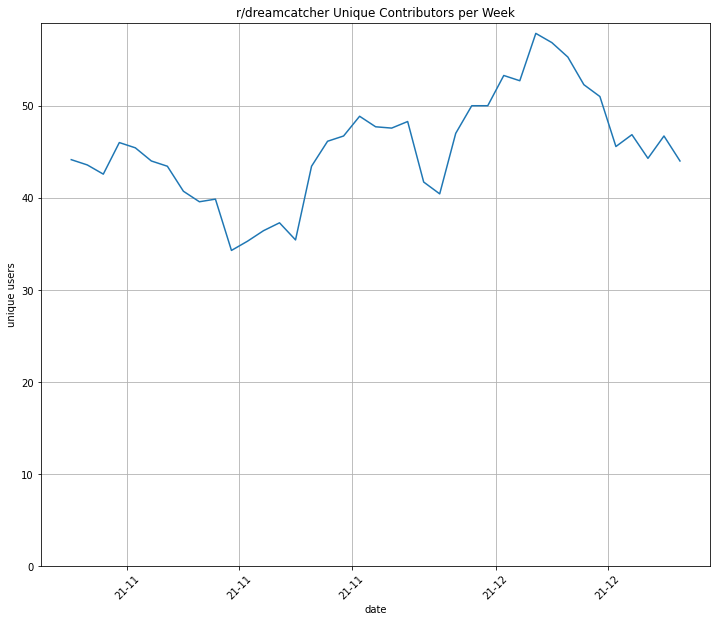

In [33]:
kernel_size = 7

# sort posts and comments by time stamp
chron_posts = SortedDict()
for key, post in posts.items():
    chron_posts[post.ts] = post
    
chron_comments = SortedDict()
for key, post in posts.items():
    for comment in post.comments:
        chron_comments[comment.ts] = comment
    
    
# unique users per week
ts_begin = start_epoch
ts_end = kernel_size * secs_in_day + ts_begin # days after ts_begin

contrib_freq_ts = []
contrib_freq = []
while ts_end < end_epoch:
    count = 0
    authors = set()
    
    # posts
    it = chron_posts.irange(ts_begin, ts_end)
    for ts in it:
        try:
            authors.add(chron_posts[ts].author.name)
        except AttributeError:
            pass
    
    # comments
    it = chron_comments.irange(ts_begin, ts_end)
    for ts in it:
        try:
            authors.add(chron_comments[ts].author.name)
        except AttributeError:
            pass
        
    count = len(authors)
    ts = (ts_begin + ts_end) / 2
    if count != 0:
        contrib_freq_ts.append(ts)
        contrib_freq.append(count)
    ts_begin += secs_in_day
    ts_end += secs_in_day
    
dates = np.array([datetime.datetime.fromtimestamp(ts, tz=datetime.timezone.utc) for ts in contrib_freq_ts])
contrib_freq = np.array(contrib_freq) / kernel_size

if len(post_freq) > 0:
    plt.figure(figsize=(12,10))
    plt.xticks(rotation=45)
    ax = plt.gca()
    xfmt = md.DateFormatter('%y-%m')
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, contrib_freq)
    plt.ylim(bottom=0)
    plt.xlabel('date')
    plt.ylabel('unique users')
    plt.title(f'r/{sub} Unique Contributors per Week')
    plt.grid(b=True, which='both', axis='both')
    
    for i,d in enumerate(dates):
        if date_scream > d:
            val_scream = contrib_freq[i]
        if date_boca > d:
            val_boca = contrib_freq[i]
        if date_online_concert > d:
            val_online_concert = contrib_freq[i]
        if date_seven_spirits > d:
            val_seven_spirits = contrib_freq[i]

    plt.annotate("Scream",
                 (date_scream,val_scream),
                 (-50, 50),
                 textcoords='offset points',
                 arrowprops={'arrowstyle': '->'})
    plt.annotate("Boca",
                 (date_boca,val_boca),
                 (-50, 50),
                 textcoords='offset points',
                 arrowprops={'arrowstyle': '->'})
    plt.annotate("Streaming Into The\nNight Online Concert",
                 (date_online_concert,val_online_concert),
                 (-50, 50),
                 textcoords='offset points',
                 arrowprops={'arrowstyle': '->'})
    plt.annotate("Seven Spirits\nOnline Concert",
                 (date_seven_spirits,val_seven_spirits),
                 (-50, 100),
                 textcoords='offset points',
                 arrowprops={'arrowstyle': '->'})
    
    plt.savefig('plots/13_uniques_time.png')
    plt.show()

## Comment and Post Counts

In [ ]:
print(f"Number of posts:    {len(posts)}")
print(f"Number of comments: {len(all_comments)}")

## I like Handong

In [ ]:
r = regex.compile(r"\bi like handong\b", flags=regex.IGNORECASE)
count = 0
total_count = 0

# search comments
for comment in all_comments:
    x = len(r.findall(comment.body))
    total_count += x
    if x >= 1:
        count += 1
        

# search post titles and selftexts
for post in posts.items():
    x = len(r.findall(post[1].title))
    y = len(r.findall(post[1].selftext))
    total_count += x+y
    if x >= 1 or y >= 1:
        count += 1
            
print(f'I like Handongs:       {count}')
print(f'Total I like Handongs: {total_count}')